Notebook putting together concepts from all modeling notebook to construct final model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
import sys
sys.path.append('./lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable, plot_rmse_instances,plot_rmse_features
#from filename import methodname
#from airbnb_modeling import
#from airbnb_modeling import

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-31_V3.csv',low_memory=False)
listings = listings.drop(listings.index[4323:4325])
listings.index = [i for i in range(len(listings))]

In [5]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [6]:
cols = [i for i in listings.columns if i not in excluded]
X = listings[cols]

In [7]:
X[X.columns[X.isnull().any()]].isnull().sum()

bathrooms    10
bedrooms      3
beds          4
dtype: int64

In [8]:
X = X.fillna(X.mean())

In [9]:
X = parse_columns(X, ['has_Pets_Allowed',
'has_Wheelchair_Accessible',
 'has_First_Aid_Kit',
 'has_Cat(s)',
 'has_24-Hour_Check-in',
 'uses_jumio',
'description-Topic0',
 'description-Topic1',
 'description-Topic4',
 'description-Topic5',
 'description-Topic6',
 'description-Topic10',
 'description-Topic11',
 'description-Topic12',
 'description-Topic13',
 'description-Topic15',
 'description-Topic17',
 'description-Topic18',
 'description-Dominant_Topic'])

In [10]:
X_normed = normalize_data(X)
y_normed = X_normed['price_y'].fillna(X_normed['price_y'].mean())
X_normed = X_normed[X_normed.columns.drop(X_normed[list(X_normed.filter(regex='price'))])]

Step1: Simple Model with Linear Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [12]:
print 'Final Number of Features Used: ', len(X_train.columns)

Final Number of Features Used:  147


In [13]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Using Cross Validation

In [15]:
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [16]:
scores_tree = cross_validate(tree_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [17]:
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)
print '----'
print '----'
print 'Evaluation Metrics for Tree Regression with CV: '
eval_metrics(scores_tree)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8380051531415182
Validation R2 Mean:  0.814293019382659
Validation R2 STdev:  0.021862904052996634
--
Training RMSE Mean:  0.024925911486976454
Validation RMSE Mean:  0.026554389453347628
Validation RMSE STdev:  6.560971232529337e-05
--
Training MAE Mean:  0.01933250370518464
Validation MAE Mean:  0.020431562030847325
Validation MAE STdev:  0.0009460618498917476
----
----
Evaluation Metrics for Tree Regression with CV: 
Training R2 Mean:  0.9999976743536301
Validation R2 Mean:  0.7279327309535808
Validation R2 STdev:  0.03606771072089454
--
Training RMSE Mean:  9.443382910423506e-05
Validation RMSE Mean:  0.03211650331351875
Validation RMSE STdev:  0.00010308351712951551
--
Training MAE Mean:  4.036039114372967e-05
Validation MAE Mean:  0.022547241246247345
Validation MAE STdev:  0.001137350278846107


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


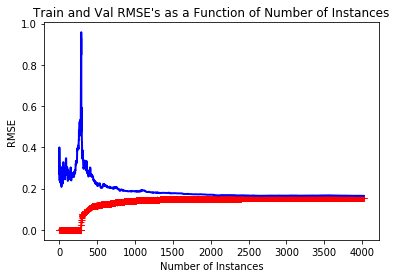

In [18]:
plot_rmse_instances(lin_reg, X_train, y_train)

In [19]:
plot_rmse_instances(tree_reg, X_train, y_train)

KeyboardInterrupt: 

Do the same for more models and create final plot

More Feature Extraction - create ratios between features

Create Feature Interactions Here

Feature Selection

In [ ]:
estimator = linear_model.LinearRegression(fit_intercept=True, normalize=False)
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_normed, y_normed)

In [ ]:
print("Optimal number of features : %d" % selector.n_features_)

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

In [ ]:
X_new = selector.transform(X_normed)

All features have equally important ranking!

In [ ]:
selector.ranking_

Now let's try Linear Regression with CV again and let's see if we have any improvements with the transformed version of X

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_new,y_normed, test_size=0.3, random_state=42)

In [ ]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train,y_train)
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, 
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)

The Validation Metrics have all (slightly) improved!

Here we would first rebuild the model only with the important features i.e. number of features where val error is lowest. But in our case, all features are equally important so there is no need to do that. 

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_normed.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking')
importances.head()

Let's add interaction features to see if our model will improve. We only select the interaction features that yield an increase in R2 above a certain arbitrary threshold

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)
increments = detect_interactions(X_normed,y_normed, 0.01)

In [ ]:
X_normed_wint = add_interactions(X_normed, increments)

In [ ]:
increments.head()

In [ ]:
X_train_int, X_test_int, y_train, y_test = train_test_split(X_normed_wint,y_normed, test_size=0.3, random_state=42)

In [ ]:
lin_reg_int = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg_int.fit(X_train_int, y_train)
scores_lin_int = cross_validate(lin_reg_int, X_train_int, y_train, cv=10, scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [ ]:
print 'Evaluation Metrics for Linear Regression with CV and Interactions Features: '
eval_metrics(scores_lin_int)

Let's pick only interaction features that minimize CV RMSE by feeding the new data into RCEFV

In [ ]:
estimator = linear_model.LinearRegression(fit_intercept=True, normalize=False)
selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train_int, y_train)
print("Optimal number of features : %d" % selector.n_features_)

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE score")
plt.title("Optimal number of features : %d" % selector.n_features_)
plt.plot(range(1, len(selector.grid_scores_) + 1), np.sqrt(-selector.grid_scores_))
plt.show()

Is it worth adding creating a new model with only important features?

In [ ]:
#X_new = selector.transform(X_normed)
#Add rest if needed

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, selector.ranking_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RFECV_Ranking'})
importances = importances.sort_values(by='RFECV_Ranking', ascending=False)

In [ ]:
best_features = list(importances.head(selector.n_features_).index)

In [ ]:
plot_rmse_features(lin_reg_int, X_train_int, y_train, best_features)

In [ ]:
#only do this after have done decision tree RFECV
#plot_rmse_features(tree_reg, X_normed, y_normed,X_normed.columns)

Finally, let's see how either of the two models performs against our Test Set

In [ ]:
test_predictions = lin_reg.predict(X_test)

In [ ]:
print 'Evaluation Metrics for LR with no Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
print 'Evaluation Metrics for LR with Interactions'
print 'Test R2: ',r2_score(y_test, test_predictions_int)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_int))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_int)

In [ ]:
listings[listings.index.isin(y_test.index)].shape

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
print 'Plot for LR with no Interactions'
plot_residuals(X_test,y_test,test_predictions)

In [ ]:
print 'Plot for LR with no Interactions'
plot_predictions(y_test,test_predictions)

Comment about results with interactions:

Let's introduce some degree of regularization to see if we can decrease validation RMSE even further

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [ ]:
lasso = linear_model.Lasso()

In [ ]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
gs = GridSearchCV(lasso, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
gs.best_params_

In [ ]:
best_model = gs.best_estimator_

In [ ]:
test_predictions = best_model.predict(X_test)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Lasso_Coef'})
importances = importances.sort_values(by='Lasso_Coef', ascending=False)

In [ ]:
importances[importances['Lasso_Coef']>0]

Now trying Ridge:

In [ ]:
ridge = linear_model.Ridge()

In [ ]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
gs = GridSearchCV(ridge, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
gs.best_params_

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Ridge_Coef'})
importances = importances.sort_values(by='Ridge_Coef', ascending=False)

In [ ]:
importances[importances['Ridge_Coef']>0]

Now Using ElasticNet

In [ ]:
en = linear_model.ElasticNet(random_state=0)

In [ ]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = [{'alpha': alphas},]
n_folds = 8

In [ ]:
gs = GridSearchCV(en, param_grid, cv=n_folds,scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
plt.figure().set_size_inches(10, 6)
plt.semilogx(alphas, val_scores)

# plot error lines showing +/- std. errors of the scores
std_error = val_scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, val_scores + std_error, 'b--')
plt.semilogx(alphas, val_scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, val_scores + std_error, val_scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(val_scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
gs.best_params_

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, np.abs(best_model.coef_)):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'EN_Coef'})
importances = importances.sort_values(by='EN_Coef', ascending=False)

In [ ]:
importances[importances['EN_Coef']>0]

Ensembles

RandomForest Regression

The Random Forest Regressor Does very well on both Training and Validation - a promising model!

In [ ]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8,10,12]},
    {'bootstrap': [True,False], 'n_estimators':[3,10], 'max_features':[2,4,6,8,10,12]},
]

In [ ]:
new_for_reg = RandomForestRegressor()

In [ ]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs_results = gs.cv_results_

In [ ]:
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

In [ ]:
imp = gs.best_estimator_.feature_importances_

In [ ]:
from operator import itemgetter
imp = pd.DataFrame(sorted(zip(X.columns, imp),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance'])

In [ ]:
imp.sort_values(by='Importance', ascending=False).head()

Now testing with Test Dataset:

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

Now trying SVR

In [ ]:
sv_reg = SVR()

In [ ]:
param_grid = [
    {'C':[i for i in range(1,20,2)], 'epsilon':[i for i in range(1,18,1)], 'kernel':['linear', 'poly', 'rbf'],
    'degree':[2,3,4]},]

In [ ]:
gs = GridSearchCV(sv_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs_results = gs.cv_results_
print 'Avg Mean Train Score: ', -gs_results['mean_train_score'].mean()
print 'Avg Mean Val Score: ', -gs_results['mean_test_score'].mean()

In [ ]:
gs.best_params_

In [ ]:
from operator import itemgetter
imp = pd.DataFrame(sorted(zip(X.columns, imp),reverse=True,key=itemgetter(1)), columns=['Feature', 'Importance'])
imp.sort_values(by='Importance', ascending=False).head()

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
plot_residuals(X_test,y_test,test_predictions)

In [ ]:
plot_predictions(y_test,test_predictions)

SVR did not give satisfactory results

Bagging Regressor

In [ ]:
br = BaggingRegressor()

In [ ]:
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[i for i in range(10,80,10)], 'bootstrap': [True,False]},
]

In [ ]:
gs = GridSearchCV(new_for_reg, param_grid, cv=4, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)

In [ ]:
print gs.best_params_
print gs.best_estimator_
gs_results = gs.cv_results_

In [ ]:
train_scores = -gs.cv_results_['mean_train_score']
train_scores_std = -gs.cv_results_['std_train_score']
val_scores = -gs.cv_results_['mean_test_score']
val_scores_std = -gs.cv_results_['std_test_score']

In [ ]:
best_model = gs.best_estimator_
test_predictions = best_model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
map_variable(y_test-test_predictions, listings)

In [ ]:
plot_residuals(X_test,y_test,test_predictions)

In [ ]:
plot_predictions(y_test,test_predictions)

Now doing nonlinear regressions with Interaction Features

In [ ]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_train_intns, y_train, 2)
test_predictions = model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)

In [ ]:
model, predictions, r2, mse, mae, rmse = nonlinear_reg(X_train_intns, y_train, 3)
test_predictions = model.predict(X_test)
print 'Test R2: ',r2_score(y_test, test_predictions)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions)